In [105]:
%reset -f

#  Первичный анализ

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression

df = pd.read_csv('heart.csv')

# посмотреть датасет
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

Размер датасета: (918, 12)

Первые 5 строк:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count 

In [107]:
# проверить пропуски
print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


# Визуализация данных

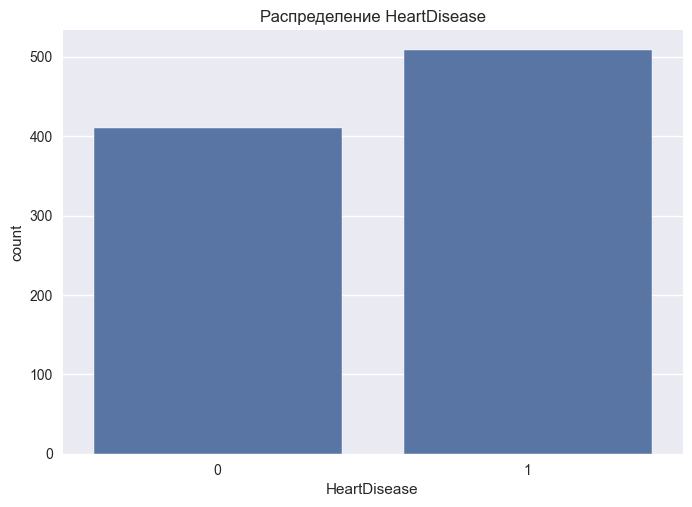

In [88]:
sns.countplot(x='HeartDisease', data=df)
plt.title('Распределение HeartDisease')
plt.show()

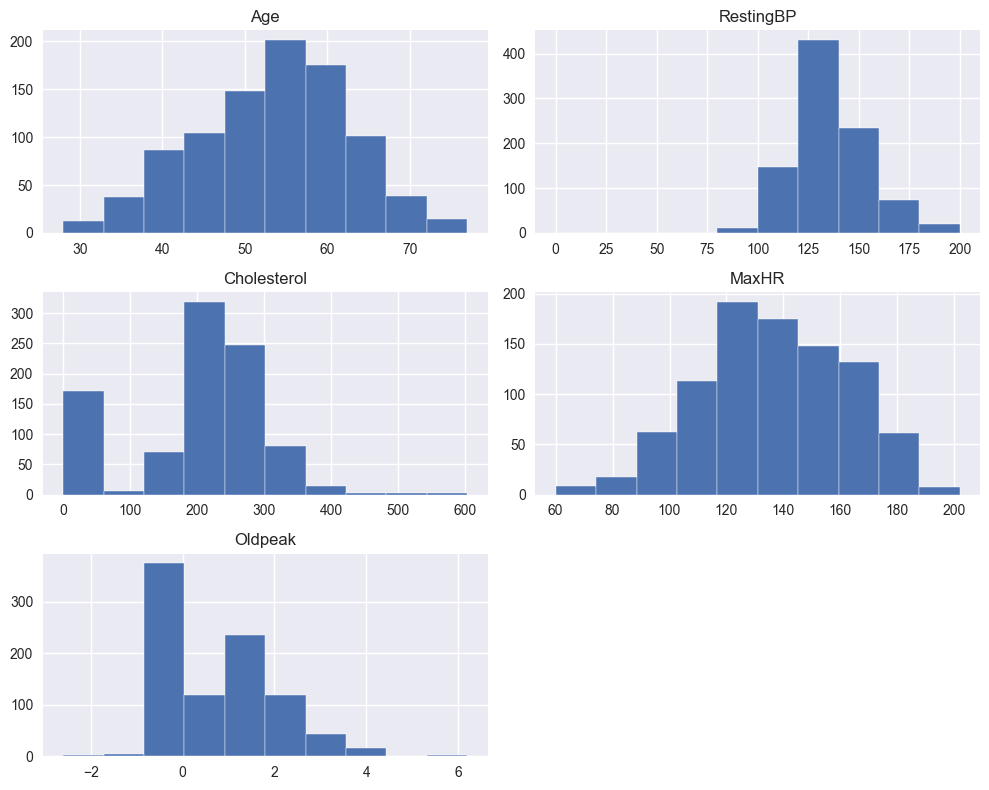

In [89]:
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[numerical].hist(figsize=(10,8))
plt.tight_layout()
plt.show()

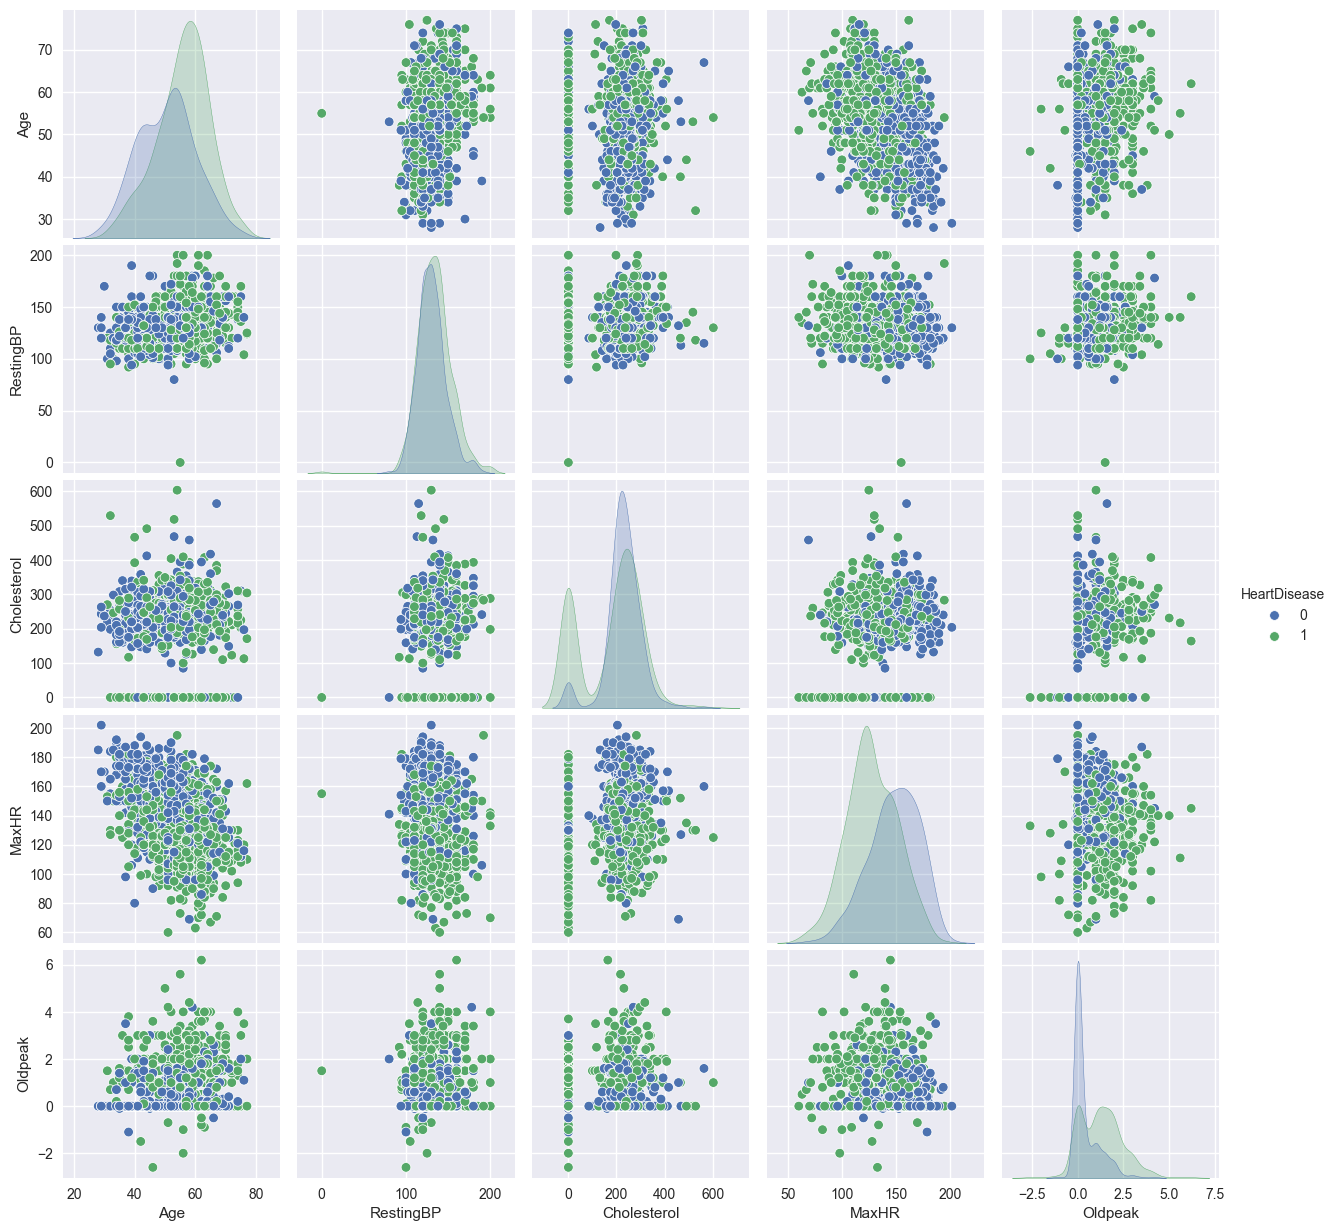

In [90]:
sns.pairplot(df, hue='HeartDisease', vars=numerical)
plt.show()

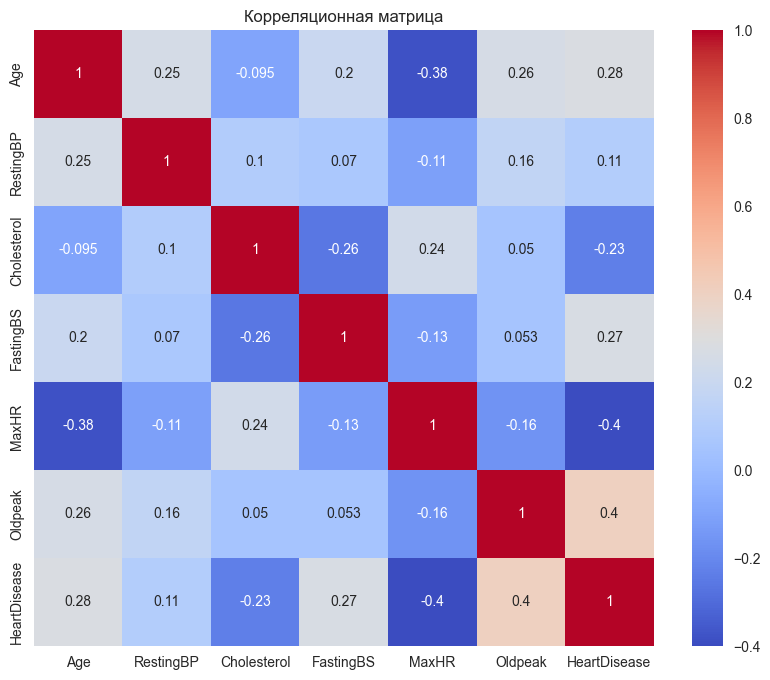

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

### Вывод по корр матрице

1. Наибольшая корреляция с целевой переменной (HeartDisease) наблюдается у признаков:
   - Age (0.28)
   - FastingBS (0.27)
   - MaxHR (-0.4)?
   - Oldpeak (0.4)
2. С другими катерогиями такая корреляция:
    - У Age и Oldpeak - 0.26
    - У Age и RestingBP - 0.25

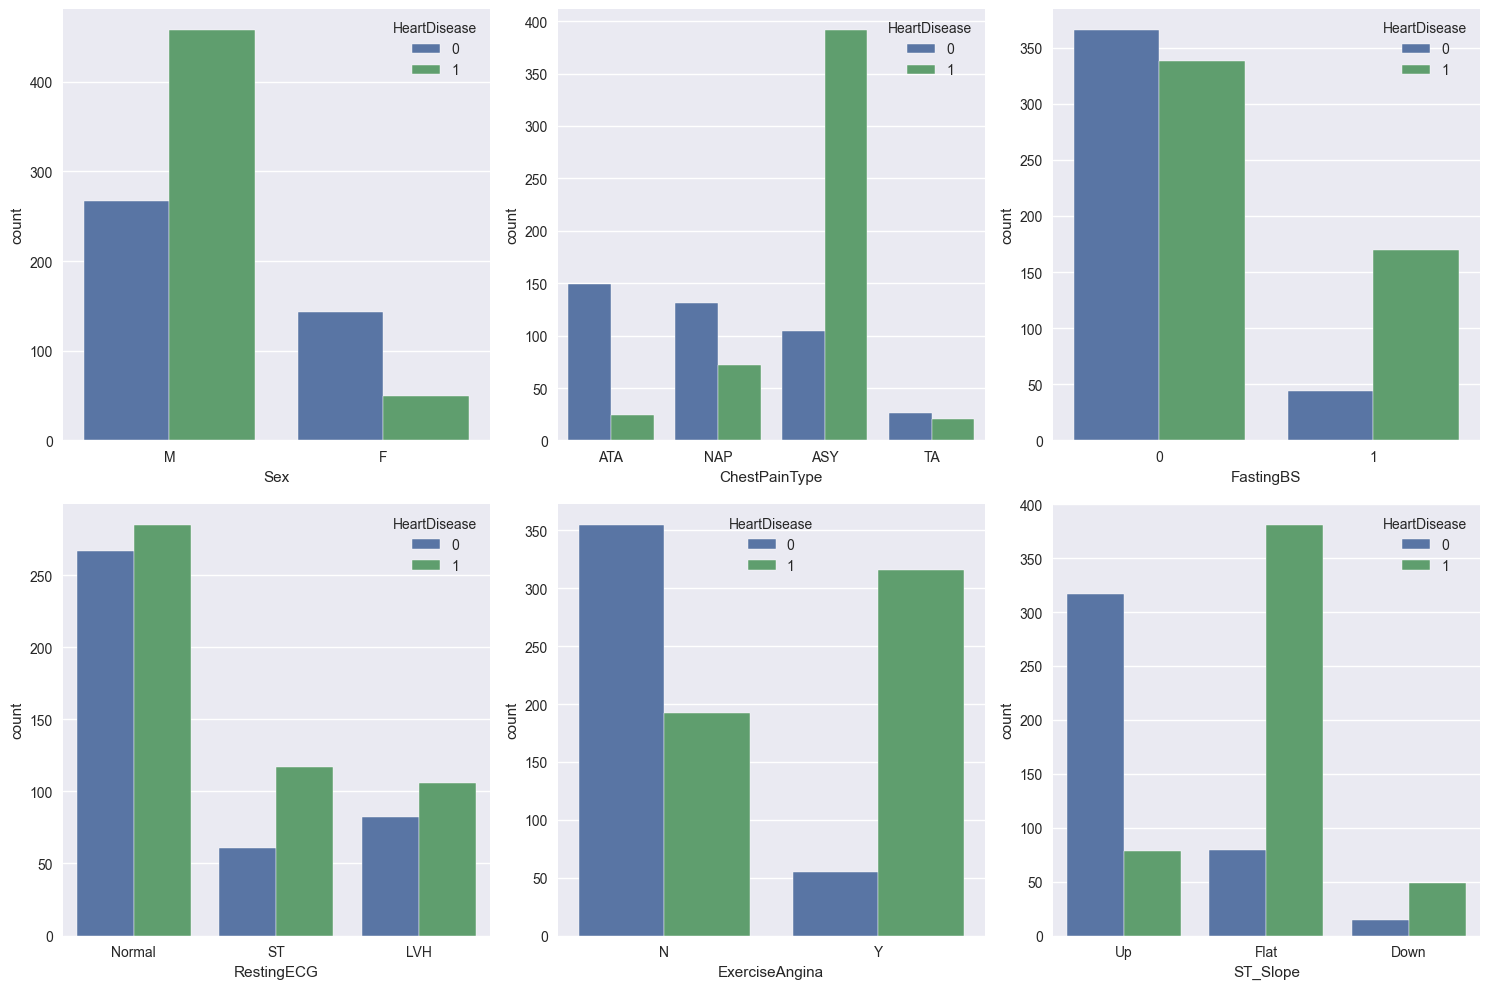

In [108]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
for col, ax in zip(categorical, axes.flatten()):
    sns.countplot(x=col, hue='HeartDisease', data=df, ax=ax)
plt.tight_layout()
plt.show()

# Масштабирование и кодирование данных

In [109]:
# кодируем всякое
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# One-Hot Encoding делаем
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

print("\nПреобразованные данные:")
print(df.head())


Преобразованные данные:
   Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0   40    1        140          289          0    172               0   
1   49    0        160          180          0    156               0   
2   37    1        130          283          0     98               0   
3   48    0        138          214          0    108               1   
4   54    1        150          195          0    122               0   

   Oldpeak  HeartDisease  ChestPainType_ATA  ChestPainType_NAP  \
0      0.0             0               True              False   
1      1.0             1              False               True   
2      0.0             0               True              False   
3      1.5             1              False              False   
4      0.0             0              False               True   

   ChestPainType_TA  RestingECG_Normal  RestingECG_ST  ST_Slope_Flat  \
0             False               True          False          Fals

In [110]:
from sklearn.model_selection import train_test_split

# тест/общ
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# масштабируем всякое
scaler = StandardScaler()
scaled_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
X[scaled_cols] = scaler.fit_transform(X[scaled_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nРазмеры выборок:\nОбучающая: {X_train.shape}\nТестовая: {X_test.shape}")


Размеры выборок:
Обучающая: (642, 15)
Тестовая: (276, 15)


# Более точный анализ после корреляционной матрицы

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, f1_score,
                            precision_score, recall_score,
                            roc_curve, confusion_matrix,
                            ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                             GradientBoostingClassifier)

# коррелируем всякое
corr_matrix = df.corr(numeric_only=True)
heart_disease_corr = corr_matrix['HeartDisease'].sort_values(ascending=False)

print("Топ-5 положительных корреляций с HeartDisease:")
print(heart_disease_corr[1:6])  # исключаем сердечное заболевание (чтоб не заболеть)

print("\nТоп-5 отрицательных корреляций с HeartDisease:")
print(heart_disease_corr[-5:])

Топ-5 положительных корреляций с HeartDisease:
ST_Slope_Flat        0.554134
ChestPainType_ASY    0.516716
ExerciseAngina       0.494282
Oldpeak              0.403951
Sex                  0.305445
Name: HeartDisease, dtype: float64

Топ-5 отрицательных корреляций с HeartDisease:
ChestPainType_NAP   -0.212964
Cholesterol         -0.232741
MaxHR               -0.400421
ChestPainType_ATA   -0.401924
ST_Slope_Up         -0.622164
Name: HeartDisease, dtype: float64


# Делим данные на выборкиии вводим метрики

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# модельки
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# учитесь, модельки
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# проверим, как учатся
print("\nСравнение точности моделей:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")


Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       123
           1       0.88      0.92      0.90       153

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276

Confusion Matrix:
[[104  19]
 [ 13 140]]

K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       123
           1       0.86      0.92      0.89       153

    accuracy                           0.87       276
   macro avg       0.88      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276

Confusion Matrix:
[[100  23]
 [ 12 141]]

Support Vector Machine:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       123
           1       0.90      0.94      0.92       153

    accuracy                   

=== Baseline модели ===

Оценка модели: LogR


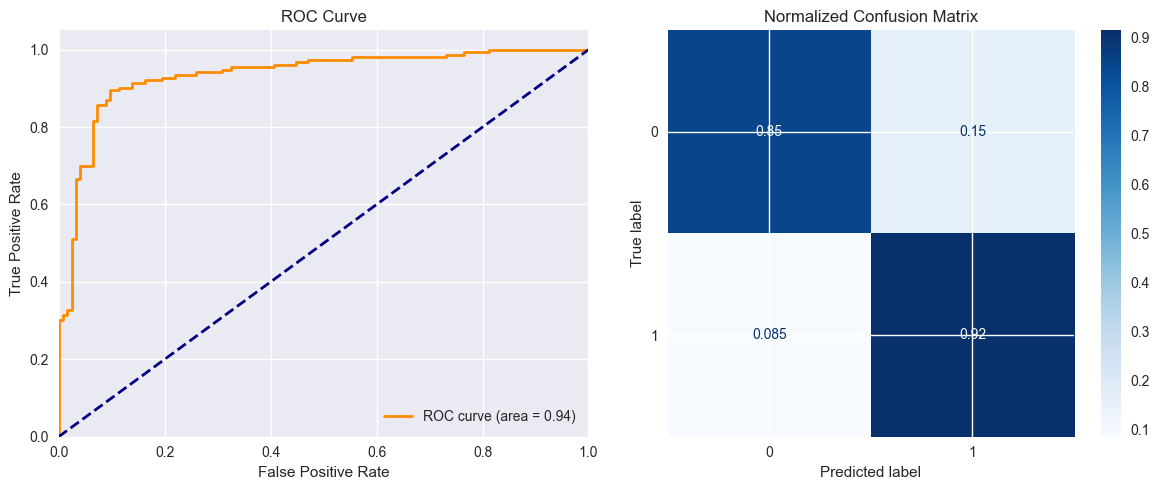


Оценка модели: KNN


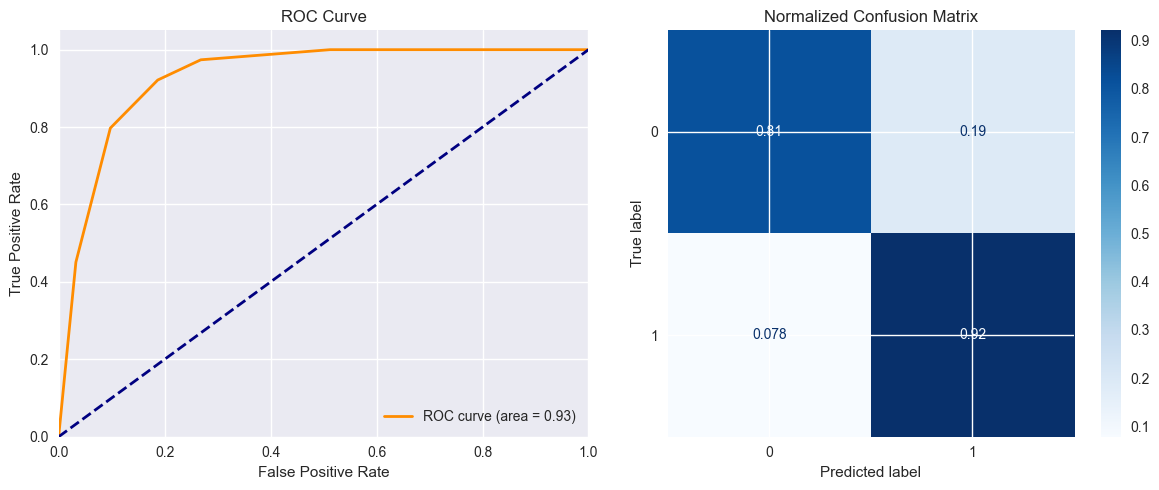


Оценка модели: SVC


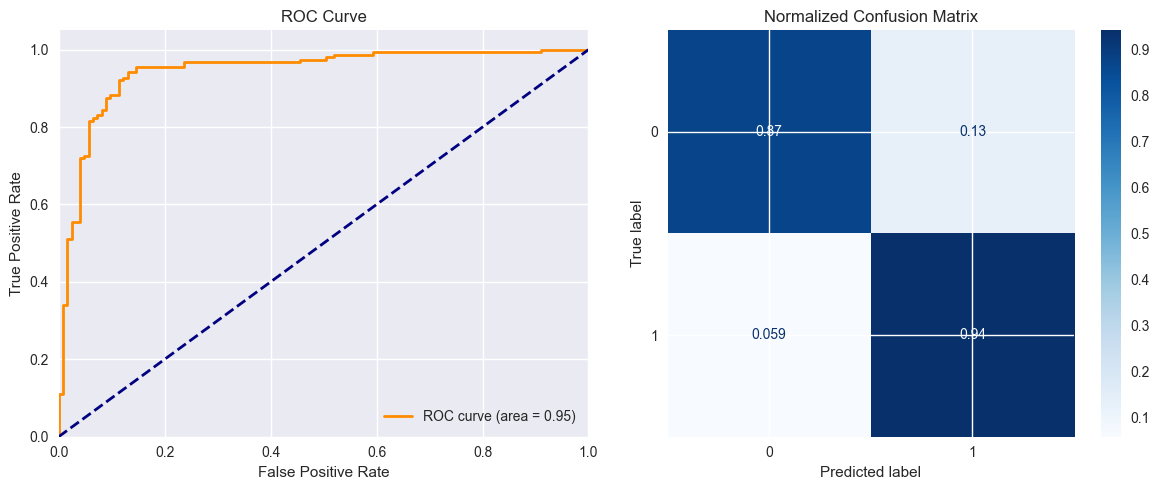


Оценка модели: Tree


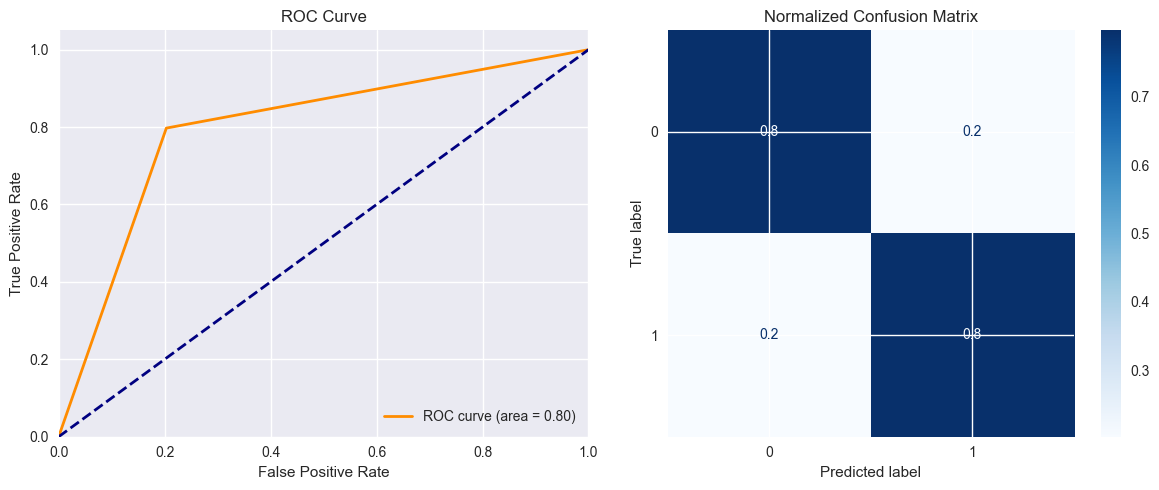


Оценка модели: RF


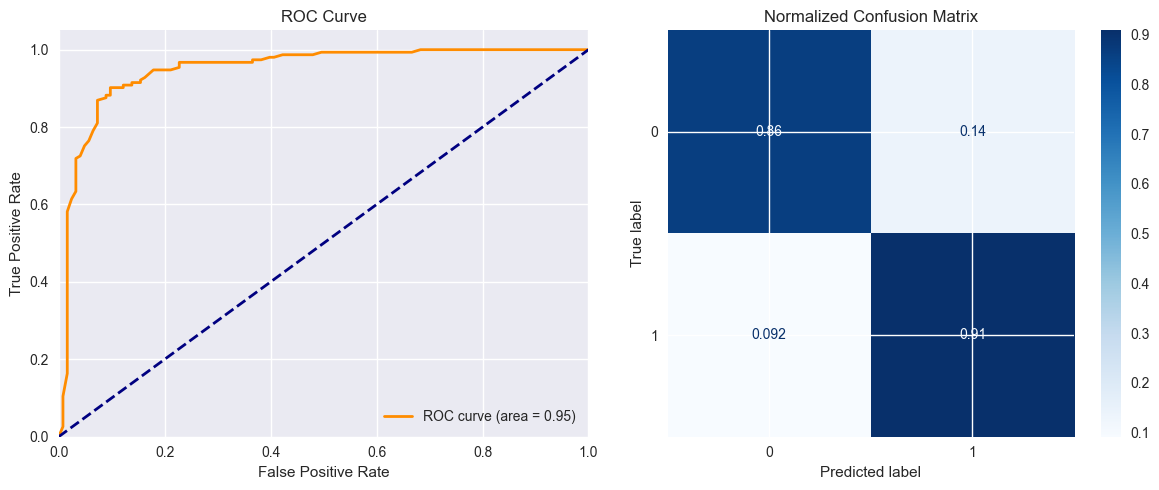


Оценка модели: GB


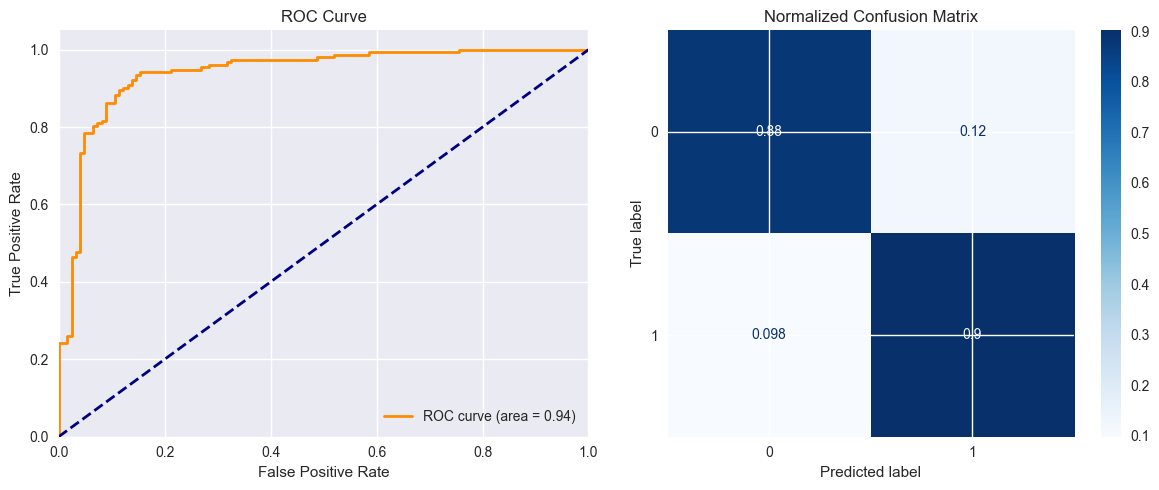


Метрики baseline-моделей:
      precision    recall        f1   roc_auc  accuracy
LogR   0.880503  0.915033  0.897436  0.935012  0.884058
KNN    0.859756  0.921569  0.889590  0.930363  0.873188
SVC    0.900000  0.941176  0.920128  0.945109  0.909420
Tree   0.829932  0.797386  0.813333  0.797067  0.797101
RF     0.891026  0.908497  0.899676  0.948616  0.887681
GB     0.901961  0.901961  0.901961  0.940539  0.891304


In [115]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

class MetricLogger:
    def __init__(self):
        self.metrics = {
            'precision': {},
            'recall': {},
            'f1': {},
            'roc_auc': {},
            'accuracy': {}
        }

    def add(self, metric_name, model_name, value):
        self.metrics[metric_name][model_name] = value

    def get_metrics(self):
        return pd.DataFrame(self.metrics)

# базовые модельки
baseline_models = {
    'LogR': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42),
    'Tree': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42)
}

# обучение
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = metrics['roc_auc']
    ax[0].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curve')
    ax[0].legend(loc="lower right")

    # матрица ошибок
    ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, ax=ax[1],
    display_labels=['0', '1'],
    cmap=plt.cm.Blues, normalize='true'
    )
    ax[1].set_title('Normalized Confusion Matrix')

    plt.tight_layout()
    plt.show()

    return metrics

baseline_results = {}
metric_logger = MetricLogger()

print("=== Baseline модели ===")
for name, model in baseline_models.items():
    print(f"\nОценка модели: {name}")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    baseline_results[name] = metrics

    for metric_name, value in metrics.items():
        metric_logger.add(metric_name, name, value)

baseline_metrics_df = metric_logger.get_metrics()
print("\nМетрики baseline-моделей:")
print(baseline_metrics_df)

# Подбор гиперпараметров с кросс-валедацией

In [117]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# мощные модельки с кастомными параметрами
param_grids = {
    'LogR': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'KNN': {
        'n_neighbors': range(3, 15),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    'Tree': {
        'max_depth': [3, 5, 7, 9, 11, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'GB': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

simplified_param_grids = {
    'LogR': {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']},
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'SVC': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
    'Tree': {'max_depth': [3, 5, None], 'min_samples_split': [2, 5]},
    'RF': {'n_estimators': [100, 200], 'max_depth': [5, None]},
    'GB': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]}
}

# подбор параметров
tuned_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== Подбор гиперпараметров ===")
for name in baseline_models.keys():
    print(f"\nПодбор параметров для: {name}")

    grid_search = GridSearchCV(
        estimator=baseline_models[name],
        param_grid=simplified_param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_

    print(f"Лучшие параметры для {name}: {grid_search.best_params_}")
    print(f"Лучший ROC-AUC: {grid_search.best_score_:.4f}")


=== Подбор гиперпараметров ===

Подбор параметров для: LogR
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшие параметры для LogR: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Лучший ROC-AUC: 0.9199

Подбор параметров для: KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Лучший ROC-AUC: 0.8917

Подбор параметров для: SVC
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для SVC: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Лучший ROC-AUC: 0.9118

Подбор параметров для: Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для Tree: {'max_depth': 3, 'min_samples_split': 2}
Лучший ROC-AUC: 0.8803

Подбор параметров для: RF
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры для RF: {'max_depth': None, 'n_estimators': 200}
Лучший ROC-AUC: 0.9136

Подбор параметров для: GB
Fitting 5 folds for each of 8 candidates, t


=== Оценка настроенных моделей ===

Оценка настроенной модели: LogR


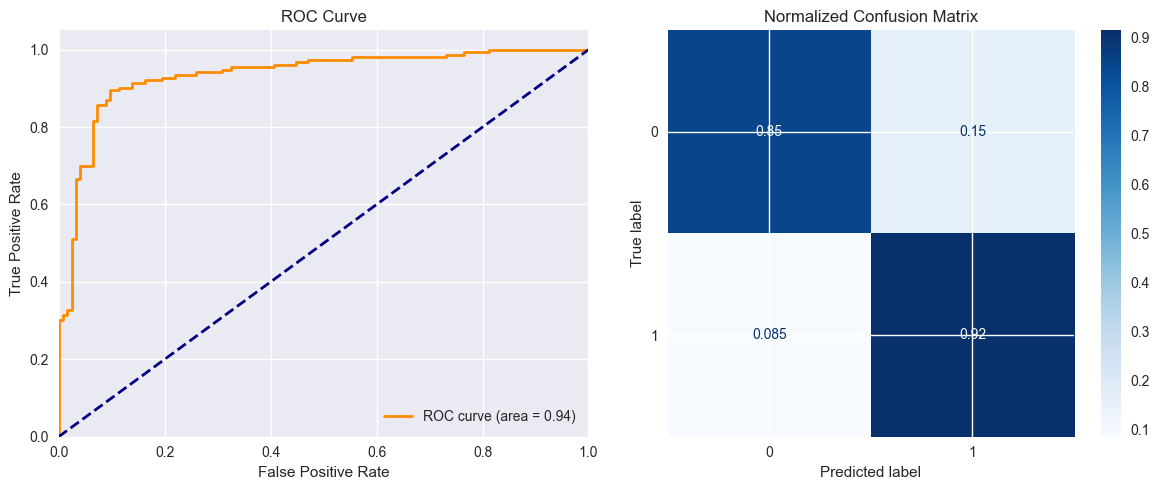


Оценка настроенной модели: KNN


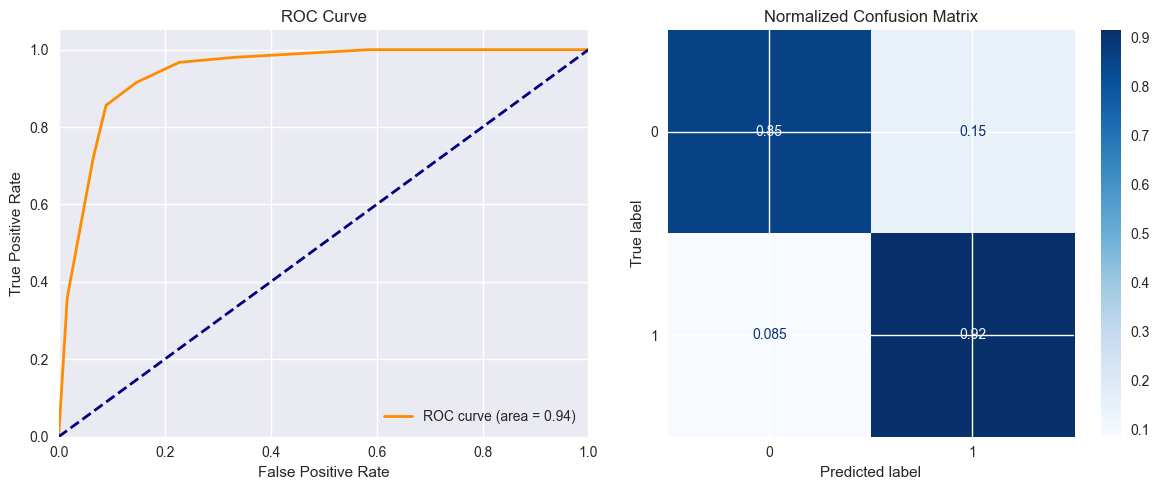


Оценка настроенной модели: SVC


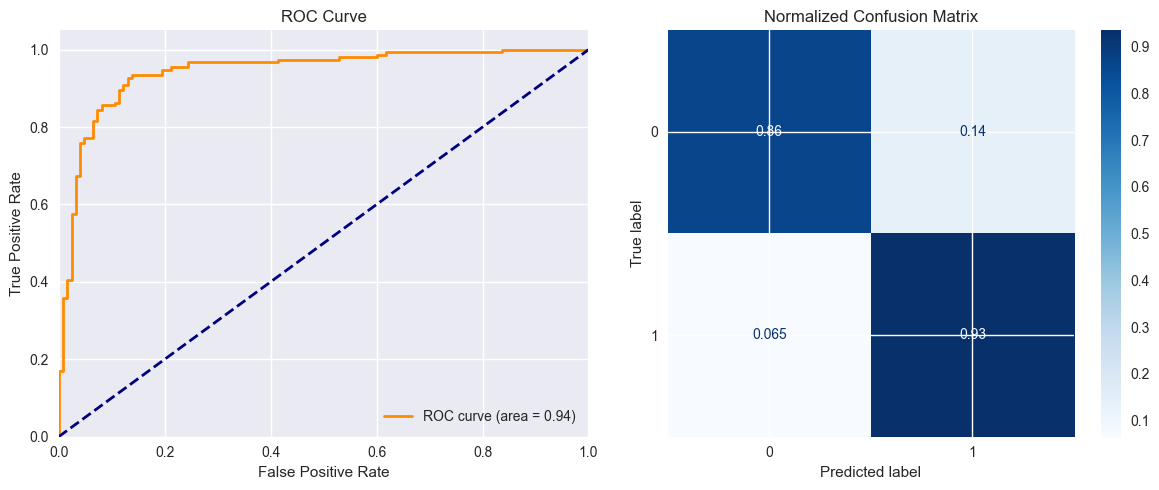


Оценка настроенной модели: Tree


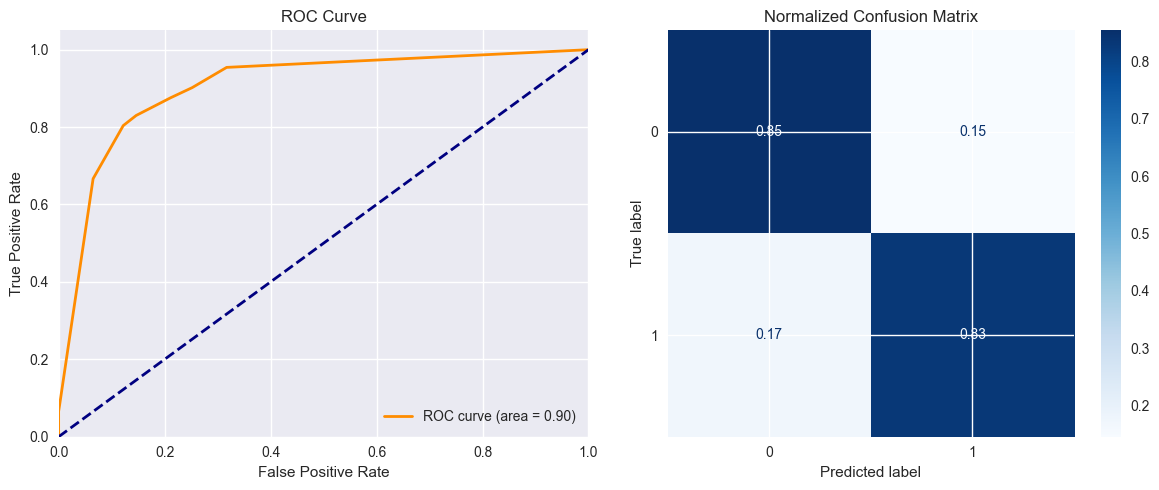


Оценка настроенной модели: RF


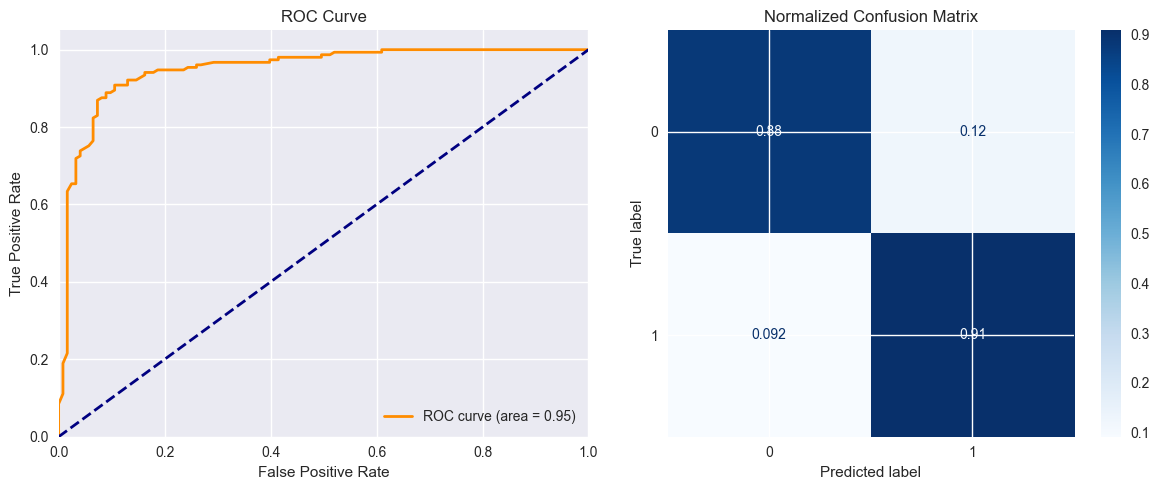


Оценка настроенной модели: GB


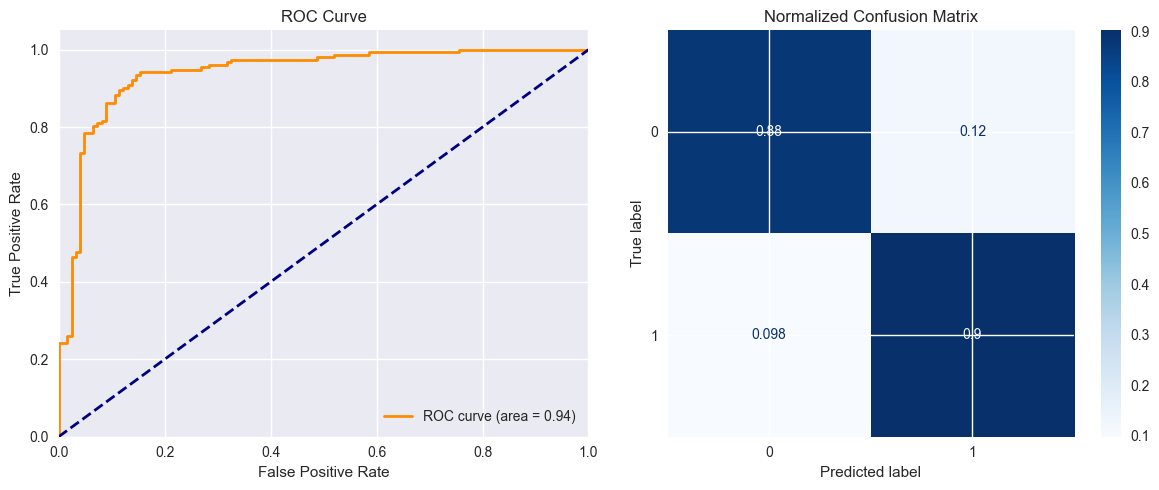


Метрики настроенных моделей:
      precision    recall        f1   roc_auc  accuracy
LogR   0.880503  0.915033  0.897436  0.935012  0.884058
KNN    0.886076  0.915033  0.900322  0.942478  0.887681
SVC    0.893750  0.934641  0.913738  0.944152  0.902174
Tree   0.875862  0.830065  0.852349  0.904857  0.840580
RF     0.902597  0.908497  0.905537  0.949546  0.894928
GB     0.901961  0.901961  0.901961  0.940539  0.891304


In [118]:
print("\n=== Оценка настроенных моделей ===")
tuned_results = {}
tuned_metric_logger = MetricLogger()

for name, model in tuned_models.items():
    print(f"\nОценка настроенной модели: {name}")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    tuned_results[name] = metrics

    for metric_name, value in metrics.items():
        tuned_metric_logger.add(metric_name, name, value)

tuned_metrics_df = tuned_metric_logger.get_metrics()
print("\nМетрики настроенных моделей:")
print(tuned_metrics_df)

# Вывод после baseline и настроенных моделей

ROC-AUC увеличился у всех моделей, кроме Logistic Regression (остался без изменений)
Accuracy улучшилась у KNN, SVC, Tree и RF
F1-score вырос у большинства моделей

Если углубиться в сами модели, то для Logistic Regression в целом ничего сильно не изменилось в метриках, то есть параметры и так были близки к оптимальным.
Для KNN ROC-AUC увеличился на 1,2%, а accuracy на 1,5%. Для SVC тоже улуились показатели, но незначительно.
Вот для Decision Tree сильно выросли ROC-AUC (10,8%) и accuracy(4,4%).
Random Forest тоже показал хороший результат с лучшим ROC-AUC, хотя выросли показатели незначительно.


Лучшая модель: RF с ROC-AUC = 0.9495


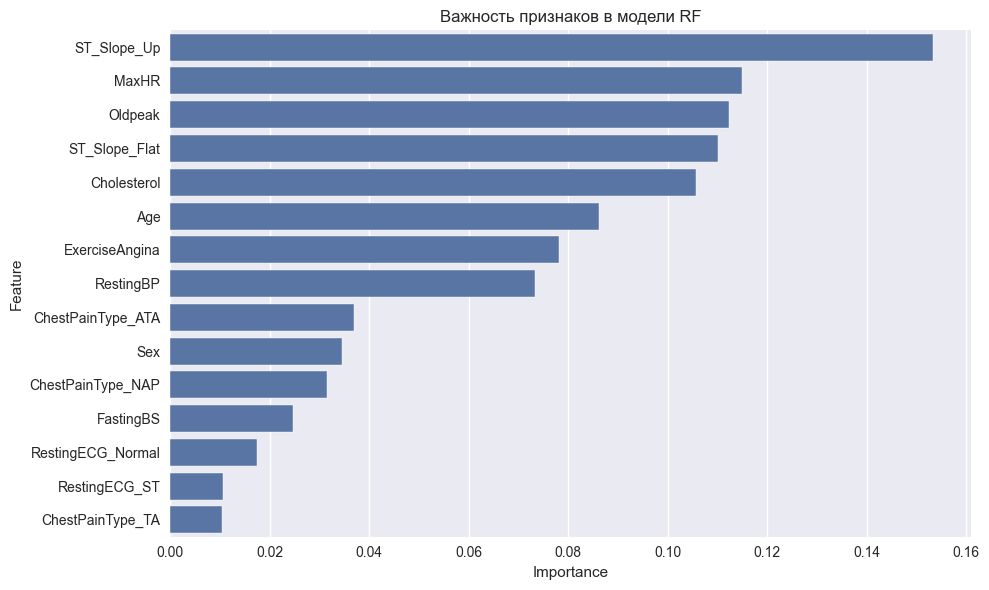

In [119]:
# смаая крутая моделька по ROC-AUC
best_model_name = max(tuned_results, key=lambda x: tuned_results[x]['roc_auc'])
best_model = tuned_models[best_model_name]

print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {tuned_results[best_model_name]['roc_auc']:.4f}")

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Важность признаков в модели {best_model_name}')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    coef = best_model.coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coef
    }).sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
    plt.title(f'Коэффициенты признаков в модели {best_model_name}')
    plt.tight_layout()
    plt.show()